In [1]:
% matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math

import scipy as scp

plt.style.use('ggplot')
sns.set_context('notebook')
sns.set_style('white')

np.set_printoptions(precision=3)
pd.set_option('precision',3)

plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 

# p2-shooting

This notebook is based on the article [*London murders: a predictable pattern?*](http://onlinelibrary.wiley.com/doi/10.1111/j.1740-9713.2009.00334.x/abstract) by David Spiegelhalter and Arthur Barnett

The data is obtained from the article [*Fatal Force*](https://www.washingtonpost.com/graphics/national/ police-shootings-2016/) by the Washington Post

In [2]:
df = pd.read_csv('fatal-police-shootings-data.csv')

In [425]:
df['date'] = pd.to_datetime(df['date'])
df.head()
# Split data from 2015-2016
#current_df, prev_df = df[df['date'].dt.year >= 2017], df[df['date'].dt.year < 2017]
#prev_df.tail()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False


In [426]:
df.tail()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
2508,2793,Isaiah Perkins,2017-07-20,shot,gun,27.0,M,NaN,St. Louis,MO,False,attack,Car,False
2509,2794,Yahir Breito,2017-07-21,shot,knife,22.0,M,NaN,Santa Ana,CA,False,other,Not fleeing,False
2510,2797,Vicente Velasquez,2017-07-21,shot,gun,42.0,M,NaN,Mission,TX,False,attack,Foot,False
2511,2795,Walter Lynde,2017-07-23,shot,toy weapon,49.0,M,W,Spencer,MA,False,attack,Car,False
2512,2796,TK TK,2017-07-23,shot,gun,59.0,M,NaN,Eau Claire,WI,True,attack,Not fleeing,False


# Frequency of shootings per day - 2015-16

In [427]:
freq = df['date'].value_counts(sort=False)
freq = freq.reindex(pd.date_range('2015-01-01', '2016-12-31'), fill_value=0)
freq = freq.sort_index()
freq.head(10)

2015-01-01    0
2015-01-02    2
2015-01-03    1
2015-01-04    3
2015-01-05    1
2015-01-06    4
2015-01-07    4
2015-01-08    4
2015-01-09    2
2015-01-10    0
Freq: D, Name: date, dtype: int64

In [428]:
freq.tail(10)

2016-12-22    1
2016-12-23    3
2016-12-24    4
2016-12-25    4
2016-12-26    0
2016-12-27    4
2016-12-28    1
2016-12-29    1
2016-12-30    3
2016-12-31    3
Freq: D, Name: date, dtype: int64

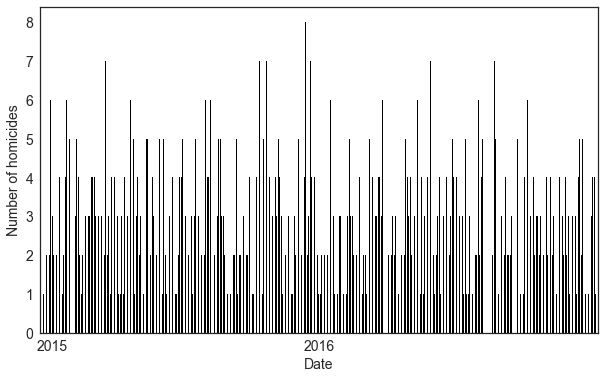

In [429]:
# Visualization of homicides throughout 2015-16
plt.figure(figsize=(10,6))
freq.plot(kind='bar', color='black')
plt.xticks([15, 365], ['2015', '2016'], rotation='horizontal', fontsize=14)

plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of homicides', fontsize=14)

#plt.savefig('assets/homicides_frequency_(ii).png', dpi=300, bbox_inches='tight', facecolor='white')

# Goodness of fit test for Poisson distribution

In [430]:
def poisson(k, x):
    """PDF for Poisson distribution"""
    return (math.exp(-k) * k**x) / math.factorial(x)

In [431]:
day_df = pd.DataFrame(freq.value_counts(sort=False))
day_df = day_df.rename(columns={'date':'Observed'})
day_df.head(10)

,Observed
0,50
1,149
2,163
3,155
4,115
5,60
6,23
7,12
8,4


In [432]:
n = sum(day_df['Observed']) # Total days
incidents = sum(day_df['Observed'] * day_df.index.values)
k = incidents/n # Estimator for poisson parameter k

day_df['Probability'] = day_df.index.map(lambda x: poisson(k, x))
day_df.set_value(8, 'Probability', 1 - sum(day_df['Probability'].head(n=8)))

day_df['Expected'] = (day_df['Probability'] * n).round(1)
day_df['Probability'] = day_df['Probability'].round(3)
day_df = day_df[['Observed', 'Expected', 'Probability']]

day_df.to_csv('assets/poisson_15_16.csv', index=True)

day_df

,Observed,Expected,Probability
0,50,50.5,0.069
1,149,134.9,0.185
2,163,180.3,0.247
3,155,160.7,0.220
4,115,107.4,0.147
5,60,57.4,0.079
6,23,25.6,0.035
7,12,9.8,0.013
8,4,4.6,0.006


# 2015-2016 Data Chi Squared Test
$H_0$: Our data follows a Poisson distribution with parameter k = 2.67

Reject $H_0$ if our random variable |$\chi^2_6$| > $\chi^2_{.05, 6}$ at significance alpha = 0.05

In [433]:
chi_test = sum((day_df['Observed'] - day_df['Expected']) ** 2 / day_df['Expected'])
chi_test

4.8326159979470455

In [434]:
scp.stats.chi2.ppf(.95, 7, loc=0, scale=1)

14.067140449340167

4.84 < 14.067, so we fail to reject $H_0$ with significance p < 0.05

# Methods of aggravation
What were the most common forms of aggravation that led to the shooting?

In [435]:
weapon_freq = df[df['date'].dt.year < 2017]['armed'].value_counts()
weapon_freq['unknown'] = weapon_freq['undetermined'] + weapon_freq['unknown weapon']
weapon_freq = weapon_freq.drop(['undetermined', 'unknown weapon'])

In [436]:
weapon_freq = df[df['date'].dt.year < 2017]['armed'].value_counts()
weapon_freq['unknown'] = weapon_freq['undetermined'] + weapon_freq['unknown weapon']
weapon_freq = weapon_freq.drop(['undetermined', 'unknown weapon'])
weapon_freq['other'] = sum(weapon_freq[weapon_freq <= 8])
weapon_freq = weapon_freq[weapon_freq > 8]
weapon_freq = weapon_freq.sort_values(ascending=False)

weapon_df = pd.DataFrame(weapon_freq)
weapon_df = weapon_df.rename(columns={'armed':'Frequency'})
weapon_df.index = weapon_df.index.str.capitalize()
weapon_df

,Frequency
Gun,1074
Knife,289
Unarmed,142
Other,119
Vehicle,119
Unknown,103
Toy weapon,87
Machete,16


In [437]:
n = sum(weapon_df['Frequency'])

weapon_df['Rank'] = weapon_df['Frequency'].rank(ascending=False).astype(int)
weapon_df['Percentile'] = ((weapon_df['Frequency'] / n) * 100).round(1)
weapon_df['Frequency'] = weapon_df['Frequency'].astype(int)

total = weapon_df[['Frequency', 'Percentile']].sum(numeric_only=True)
total.name = 'Total'
weapon_df = weapon_df.append(total)

weapon_df = weapon_df[['Rank', 'Frequency', 'Percentile']]


# For formatting
weapon_df['Rank'] = weapon_df['Rank'].astype(str).str.rstrip('.0')
weapon_df['Frequency'] = weapon_df['Frequency'].astype(str).str.rstrip('.0')
weapon_df.set_value('Total', 'Rank', '')
weapon_df.set_value('Total', 'Percentile', 100)

weapon_df.to_csv('assets/weapons.csv', index_label='Method of Aggravation')

weapon_df

,Rank,Frequency,Percentile
Gun,1,1074,55.1
Knife,2,289,14.8
Unarmed,3,142,7.3
Other,4,119,6.1
Vehicle,4,119,6.1
Unknown,6,103,5.3
Toy weapon,7,87,4.5
Machete,8,16,0.8
Total,,1949,100.0


# Predicted homicides on Poisson distribution vs. observed homicides

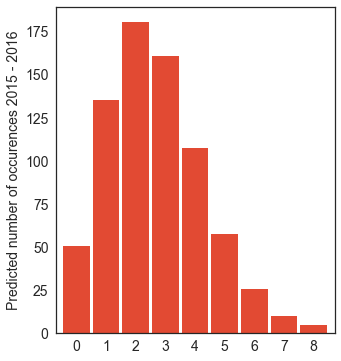

In [438]:
plt.figure(figsize=(5,6))

day_df['Expected'].plot(kind='bar', width=0.9, rot=0)
plt.ylabel('Predicted number of occurences 2015 - 2016', fontsize=14)
#plt.xlabel('Homicides per day', fontsize=14)

#plt.savefig('assets/day_frequency_poisson_(iiia).png', dpi=300, bbox_inches='tight', facecolor='white')

plt.show()

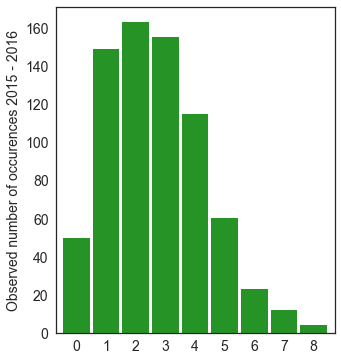

In [439]:
plt.figure(figsize=(5,6))

day_df['Observed'].plot(kind='bar', color='green', width=0.9, rot=0, alpha=0.85)
plt.ylabel('Observed number of occurences 2015 - 2016', fontsize=14)
#plt.xlabel('Homicides per day', fontsize=14)

#plt.savefig('assets/day_frequency_poisson_(iiib).png', dpi=300, bbox_inches='tight', facecolor='white')

plt.show()

# Frequency of shootings per weekday, month

Is there a significant week or month where shootings occur?

In [471]:
wk_freq = df[df['date'].dt.year < 2017]['date'].dt.weekday.value_counts()
wk_freq = wk_freq.sort_index()
wk_freq.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
wk_freq

Monday       249
Tuesday      294
Wednesday    307
Thursday     285
Friday       273
Saturday     269
Sunday       277
Name: date, dtype: int64

In [472]:
month_freq = df['date'].dt.month.value_counts()
month_freq = month_freq.sort_index()
month_freq.index = ['January',
                    'February',
                    'March', 
                    'April',
                    'May',
                    'June',
                    'July',
                    'August', 
                    'September', 
                    'October', 
                    'November',
                    'December']

month_freq

January      249
February     263
March        260
April        224
May          219
June         241
July         242
August       176
September    160
October      158
November     154
December     167
Name: date, dtype: int64

In [473]:
wk_freq.to_csv('assets/wk_freq.csv')
month_freq.to_csv('assets/month_freq.csv')

In [474]:
wk_freq

Monday       249
Tuesday      294
Wednesday    307
Thursday     285
Friday       273
Saturday     269
Sunday       277
Name: date, dtype: int64

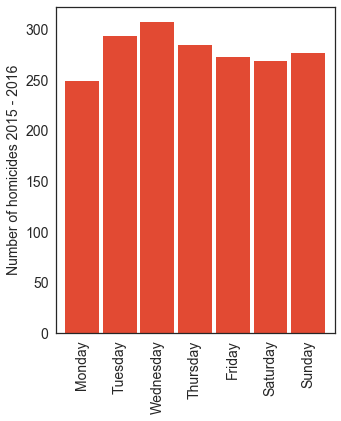

In [475]:
plt.figure(figsize=(5,6))

wk_freq.plot(kind='bar', width=0.9)
plt.xticks(np.arange(7), ['Monday',
                          'Tuesday',
                          'Wednesday',
                          'Thursday',
                          'Friday',
                          'Saturday',
                          'Sunday'], fontsize=14)
plt.ylabel('Number of homicides 2015 - 2016', fontsize=14)

plt.savefig('assets/week_month_frequency_(iva).png', dpi=300, bbox_inches='tight', facecolor='white')

plt.show()

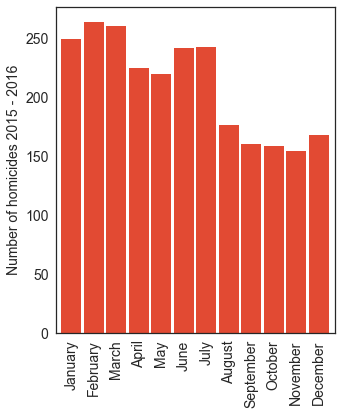

In [476]:
plt.figure(figsize=(5,6))

month_freq.plot(kind='bar', width=0.9)
plt.xticks(np.arange(12), ['January',
                           'February',
                           'March', 'April',
                           'May',
                           'June',
                           'July',
                           'August', 
                           'September', 
                           'October', 
                           'November',
                           'December'], fontsize=14)
plt.ylabel('Number of homicides 2015 - 2016', fontsize=14)

plt.savefig('assets/week_month_frequency_(ivb).png', dpi=300, bbox_inches='tight', facecolor='white')

plt.show()

In [502]:
wk_df['mean'] 

0    2.394
1    2.827
2    2.952
3    2.714
4    2.600
5    2.562
6    2.663
Name: mean, dtype: float64

In [512]:
freq.head()

3    0
4    2
5    1
6    3
0    1
Name: date, dtype: int64

0    338.701
1    273.150
2    203.959
3    279.802
4    232.075
5    360.125
6    276.366
dtype: float64

In [509]:
freq.groupby(freq.index).

In [520]:
wk_df

,total,mean,SStr
0,249,2.394,338.701
1,294,2.827,273.150
2,307,2.952,203.959
3,285,2.714,279.802
4,273,2.600,232.075
5,269,2.562,360.125
6,277,2.663,276.366


In [534]:
data = pd.DataFrame(freq)

In [540]:
sum((freq - freq.mean())**2)

1984.8590971272315

In [541]:
wk_df['total']

0    249
1    294
2    307
3    285
4    273
5    269
6    277
Name: total, dtype: int64

In [542]:
wk_df['mean']

0    2.394
1    2.827
2    2.952
3    2.714
4    2.600
5    2.562
6    2.663
Name: mean, dtype: float64

In [547]:
sum(freq.subtract(wk_df['mean'], level=freq.index)**2)

1964.1781135531016

In [ ]:
ols('weight ~ Time + C(Diet)', data=cw).fit() #Specify C for Categorical
print(sm.stats.anova_lm(cw_lm, typ=2))

In [566]:
monday = freq[freq.index == 0]
tuesday = freq[freq.index == 1]
wednesday = freq[freq.index == 2]
thursday = freq[freq.index == 3]
friday = freq[freq.index == 4]
saturday = freq[freq.index == 5]
sunday = freq[freq.index == 6]

In [567]:
scp.stats.f_oneway(monday, tuesday, wednesday, thursday, friday, saturday, sunday)

F_onewayResult(statistic=1.270508684551835, pvalue=0.26856489810785505)

In [605]:
wk_df = pd.DataFrame(freq.groupby(freq.index).sum())
wk_df = wk_df.rename(columns={'date':'Total'})
wk_df['Mean'] = freq.groupby(freq.index).mean()

mean_tot = freq.mean()
SS_tot = sum((freq - mean_tot) ** 2) #good
SStr = sum(wk_df['Total'] * (wk_df['Mean'] - mean_tot)**2)
SSE = sum((freq - wk_df['Mean'])**2)

#wk_df['SStr'] = ((freq - wk_df['Mean'])**2).groupby(freq.index).sum()
#wk_df['SStot']

In [606]:
wk_df.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [651]:
anova = pd.DataFrame(np.array([['6', SStr, MStr, MStr/MSE]]), index=['Treatment'], columns=['Degrees of Freedom', 'Sum of Squares', 'Mean Square', 'F-value'])



In [652]:
anova = anova.append(pd.DataFrame(np.array([[N-k, SSE, MSE, '']]), index=['Error'], columns=['Degrees of Freedom', 'Sum of Squares', 'Mean Square', 'F-value']))
anova = anova.append(pd.DataFrame(np.array([[N-1, SS_tot, '', '']]), index=['Total'], columns=['Degrees of Freedom', 'Sum of Squares', 'Mean Square', 'F-value']))       
            
 
             
             

In [658]:
anova['Sum of Squares'] = anova['Sum of Squares'].round(2)

In [676]:
anova.set_value('Treatment', 'Sum of Squares', 20.68)

,Degrees of Freedom,Sum of Squares,Mean Square,F-value
Treatment,6,20.68,3.44,1.27
Error,724,1964.18,2.71,
Total,730,1984.86,,


In [673]:
anova = anova.drop('SSE', axis=1)

In [677]:
anova

,Degrees of Freedom,Sum of Squares,Mean Square,F-value
Treatment,6,20.68,3.44,1.27
Error,724,1964.18,2.71,
Total,730,1984.86,,


In [678]:
anova.to_csv('assets/anova.csv')

In [655]:
anova['Sum of Squares'] = anova['Sum of Squares'].astype(float)
anova['Mean Square'] = anova['Mean Square'].astype(float, errors='ignore')
anova['Sum of Squares'] = anova['Sum of Squares'].astype(float, errors='ignore')

ValueError: could not convert string to float: 

In [649]:
anova

,Degrees of Freedom,Sum of Squares,Mean Square,F-value
Treatment,6,55.484,3.44683059569,1.27050868455
Error,724,1964.178,2.71295319552,
Total,730,1984.859,,


In [573]:
N = len(freq)
k = 7

In [574]:
SS_tot

1984.8590971272315

In [575]:
SStr = SS_tot - SSE
SStr

20.680983574129868

In [576]:
SSE

1964.1781135531016

In [579]:
MSE = SSE / (N - k)
MStr = SStr/ (k-1)

In [581]:
MStr / MSE

1.2705086845530984

In [597]:
data = pd.DataFrame(wk_freq)
data = data.rename(columns={'date':'Total'})
data['Mean'] = pd.Series(wk_df['mean'])

In [550]:
data = pd.DataFrame(columns=['Degrees of Freedom', 'Sum of Squares', 'Mean Square', 'F value'])

In [563]:
data.set_index(keys=['Treatment', 'Error', 'Total'], append=True)

TypeError: 'list' object is not callable

In [557]:
data

,Degrees of Freedom,Sum of Squares,Mean Square,F value


In [490]:
wk_df

,total,mean
0,249,2.394
1,294,2.827
2,307,2.952
3,285,2.714
4,273,2.600
5,269,2.562
6,277,2.663


In [480]:
freq.groupby(freq.index).mean()

0    2.394
1    2.827
2    2.952
3    2.714
4    2.600
5    2.562
6    2.663
Name: date, dtype: float64

In [479]:
wk_freq

Monday       249
Tuesday      294
Wednesday    307
Thursday     285
Friday       273
Saturday     269
Sunday       277
Name: date, dtype: int64

,date
Monday,249
Tuesday,294
Wednesday,307
Thursday,285
Friday,273
Saturday,269
Sunday,277


# Prediction Intervals

In [413]:
xplt = np.arange(365)
freq_15 = freq.reindex(pd.date_range('2015-01-01', '2015-12-31'), fill_value=0)
freq_16 = freq.reindex(pd.date_range('2016-01-01', '2016-12-31'), fill_value=0)
freq_17 = df[df['date'].dt.year == 2017]['date'].value_counts().reindex(pd.date_range('2017-01-01', '2017-07-23'), fill_value=0)

In [414]:
def predictionBand(x, c='black', ls=':', lab='_nolegend_'):
    m = np.arange(1, len(x)+1)
    n = m
    y_hat = x * m / n
    
    z = scp.stats.norm.ppf(.975)
    delta = z * np.sqrt(m*y_hat*(2/m))
    
    U = y_hat + delta
    L = y_hat - delta
    
    plt.plot(n, U, color=c, linestyle=ls, label=lab)
    plt.plot(n, L, color=c, linestyle=ls, label='_nolegend_')

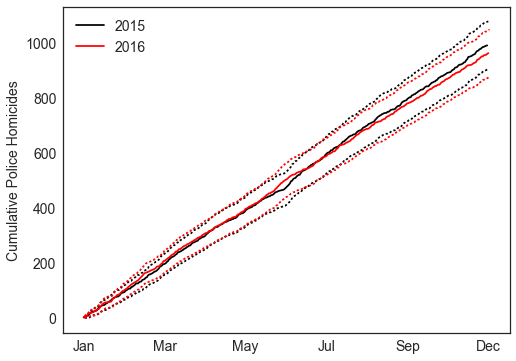

In [421]:
plt.figure(figsize=(8,6))

plt.plot(np.arange(len(freq_15)), freq_15.cumsum(), color='black', label='2015')
predictionBand(freq_15.cumsum())

plt.plot(np.arange(len(freq_16)), freq_16.cumsum(), color='red', label='2016')
predictionBand(freq_16.cumsum(), 'red')

plt.ylabel('Cumulative Police Homicides', fontsize=14)
plt.legend(fontsize=14)
plt.xticks(np.linspace(0, 365, 11), ['Jan', ' ', 'Mar', ' ', 'May', ' ', 'Jul', ' ', 'Sep', ' ', 'Dec']);

plt.savefig('assets/cumulative_homicides_(ixa).png', dpi=300, bbox_inches='tight', facecolor='white')

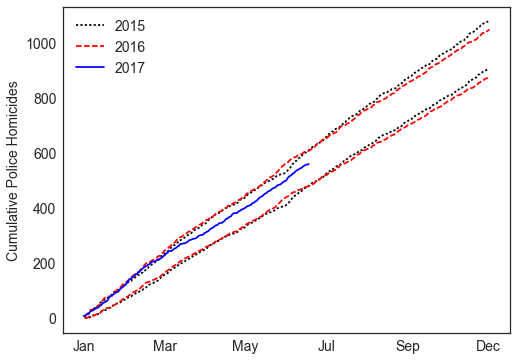

In [422]:
plt.figure(figsize=(8,6))

predictionBand(freq_15.cumsum(), lab='2015')
predictionBand(freq_16.cumsum(), 'red', '--', '2016')
plt.plot(np.arange(len(freq_17)), freq_17.cumsum(), 'blue', label='2017')

plt.ylabel('Cumulative Police Homicides', fontsize=14)
plt.legend(fontsize=14)

plt.xticks(np.linspace(0, 365, 11), ['Jan', ' ', 'Mar', ' ', 'May', ' ', 'Jul', ' ', 'Sep', ' ', 'Dec']);

plt.savefig('assets/cumulative_homicides_(ixb)', dpi=300, bbox_inches='tight', facecolor='white')

# Goodness of Fit test for 2017 data

In [278]:
freq = df['date'].value_counts(sort=False)
freq = freq.reindex(pd.date_range('2017-01-01', '2017-07-23'), fill_value=0) # Current date: July 23, 2017
freq = freq.sort_index()
freq.head(10)

2017-01-01    6
2017-01-02    0
2017-01-03    2
2017-01-04    4
2017-01-05    2
2017-01-06    2
2017-01-07    6
2017-01-08    1
2017-01-09    2
2017-01-10    2
Freq: D, Name: date, dtype: int64

In [300]:
day_df = pd.DataFrame(freq.value_counts(sort=False))
day_df = day_df.rename(columns={'date':'Observed'})
day_df

,Observed
0,13
1,36
2,47
3,48
4,33
5,14
6,10
7,1
8,2


In [301]:
n = sum(day_df['Observed'])
k = sum(day_df['Observed'] * day_df.index.values)/n

print('There are {} values with estimator k = {}'.format(n, k))
day_df

There are 204 values with estimator k = 2.7401960784313726


,Observed
0,13
1,36
2,47
3,48
4,33
5,14
6,10
7,1
8,2


In [302]:
day_df['Probability'] = day_df.index.map(lambda x: poisson(k, x))
day_df.set_value(8, 'Probability', 1 - sum(day_df['Probability'].head(n=8)))

day_df['Expected'] = (day_df['Probability'] * n).round(1)
day_df['Probability'] = day_df['Probability'].round(3)

day_df = day_df[['Observed', 'Expected', 'Probability']]
day_df.to_csv('assets/poisson_17_a.csv', index=True)

day_df

,Observed,Expected,Probability
0,13,13.2,0.065
1,36,36.1,0.177
2,47,49.4,0.242
3,48,45.2,0.221
4,33,30.9,0.152
5,14,17.0,0.083
6,10,7.7,0.038
7,1,3.0,0.015
8,2,1.5,0.007


In [303]:
# In order to apply the chi-squared test, there must be at least 80% expected values > 5
# We merge the last two rows so that there is only 1 less than 5, which is less than 20% of 8 bins
day_df.iloc[7] = day_df.iloc[7] + day_df.iloc[8]
day_df = day_df.drop(day_df.index[8])
day_df['Observed'] = day_df['Observed'].astype(int)

In [304]:
# Recalculate poisson and expected
day_df['Probability'] = day_df.index.map(lambda x: poisson(k, x))
day_df.set_value(7, 'Probability', 1 - sum(day_df['Probability'].head(n=7)))

day_df['Expected'] = (day_df['Probability'] * n).round(1)
day_df['Probability'] = day_df['Probability'].round(3)

#day_df = day_df[['Observed', 'Expected', 'Probability']]
day_df.to_csv('assets/poisson_17_b.csv')

day_df

,Observed,Expected,Probability
0,13,13.2,0.065
1,36,36.1,0.177
2,47,49.4,0.242
3,48,45.2,0.221
4,33,30.9,0.152
5,14,17.0,0.083
6,10,7.7,0.038
7,3,4.5,0.022


# 2017 Data Chi Squared Test
$H_0$: Our data follows a Poisson distribution with parameter k = 2.74

Reject $H_0$ if our random variable |$\chi^2_6$| > $\chi^2_{.05, 6}$ at significance alpha = 0.05

In [36]:
chi_test = sum((day_df['Observed'] - day_df['Expected'])**2 / day_df['Expected'])
chi_test

2.152501027378392

In [37]:
chi2.ppf(.95, 6, loc=0, scale=1)

12.591587243743977

$1.61 < 12.59$ so we fail to reject $H_0$; there is not enough evidence that the data is not poisson distributed.

In [209]:
test = np.zeros(365)
test += 0.44

In [219]:
y_hat = test.cumsum()
delta = np.sqrt(m * y_hat * (1/m + 1/n))

(0, 200)

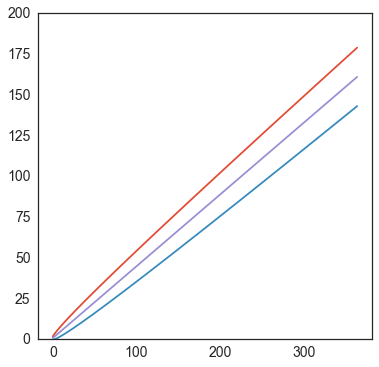

In [226]:
plt.figure(figsize=(6,6))

plt.plot(y_hat + delta)
plt.plot(y_hat - delta)
plt.plot(test.cumsum())

plt.ylim(0, 200)